## Machine Learning Pipeline for High-Entropy Alloy Discovery and Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, silhouette_score, mean_squared_error, get_scorer_names
from statsmodels.stats.diagnostic import lilliefors
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import RFE 
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [2]:
data = pd.read_csv("Data_base.csv")
#data.describe()
data = data.iloc[:, 1:]

X = data[['Fe','Ni','Co','Cr','V','Cu','VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M']]
data = data.rename(columns={'TEC': 'CTE'})

y = data[['CTE']]
var = X.var()
zero_var_columns = var[var == 0].index.to_list()

zero_var_columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#for column in X.columns:
#    sns.boxplot(x=X[column])
#    plt.title(f'Boxplot of {column}')
#    plt.savefig(f"boxplot_{column}.png")
#    plt.show()

In [ ]:
sns.set_style('whitegrid')
contamination = 0.05
iso_forest = IsolationForest(contamination=contamination, random_state=42)
outliers_iso = iso_forest.fit_predict(X_scaled)
outliers_data_iso = data[outliers_iso == -1]
print(f"Isolation Forest - {len(outliers_data_iso)}")

lof = LocalOutlierFactor(n_neighbors=15, contamination=contamination)
outliers_lof = lof.fit_predict(X_scaled)
outliers_data_lof = data[outliers_lof == -1]
print(f"LOF - {len(outliers_data_lof)}")

svm = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination)
outliers_svm = svm.fit_predict(X_scaled)
outliers_data_svm = data[outliers_svm == -1]
print(f"One-Class SVM - {len(outliers_data_svm)}")


iso_outliers_set = set(outliers_data_iso.index)
lof_outliers_set = set(outliers_data_lof.index)
svm_outliers_set = set(outliers_data_svm.index)

common_outliers = iso_outliers_set.intersection(lof_outliers_set, svm_outliers_set)
print(f"Outlier detected by all three - {len(common_outliers)} they are{common_outliers}")

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color='#ADB5BD', edgecolors='black',linewidths= 0.6, alpha=0.6, label='Inliers')

plt.scatter(X_tsne[list(iso_outliers_set), 0], X_tsne[list(iso_outliers_set), 1],linewidths= 0.6, color='#6A0DAD',edgecolors='black', label='Isolation Forest Outliers')
plt.scatter(X_tsne[list(lof_outliers_set), 0], X_tsne[list(lof_outliers_set), 1],linewidths= 0.6, color='#008080',edgecolors='black', label='LOF Outliers')
plt.scatter(X_tsne[list(svm_outliers_set), 0], X_tsne[list(svm_outliers_set), 1],linewidths= 0.6, color='#40E0D0', edgecolors='black', label='One-Class SVM Outliers')

plt.scatter(X_tsne[list(common_outliers), 0], X_tsne[list(common_outliers), 1], color='black', label='Common Outliers', marker='x')

plt.legend()
#plt.savefig('tsne_plot_with_outliers.png', dpi = 400)
all_outliers = set.union(iso_outliers_set, lof_outliers_set, svm_outliers_set)

data_cleaned = data.drop(index=list(all_outliers))

X = data_cleaned[['Fe','Ni','Co','Cr','V','Cu','VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M']]
y = data_cleaned[['TEC']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Shape of input vector (717, 17)
Shape of output y (717, 1)
CTE   -1.07
dtype: float64 CTE    23.2
dtype: float64


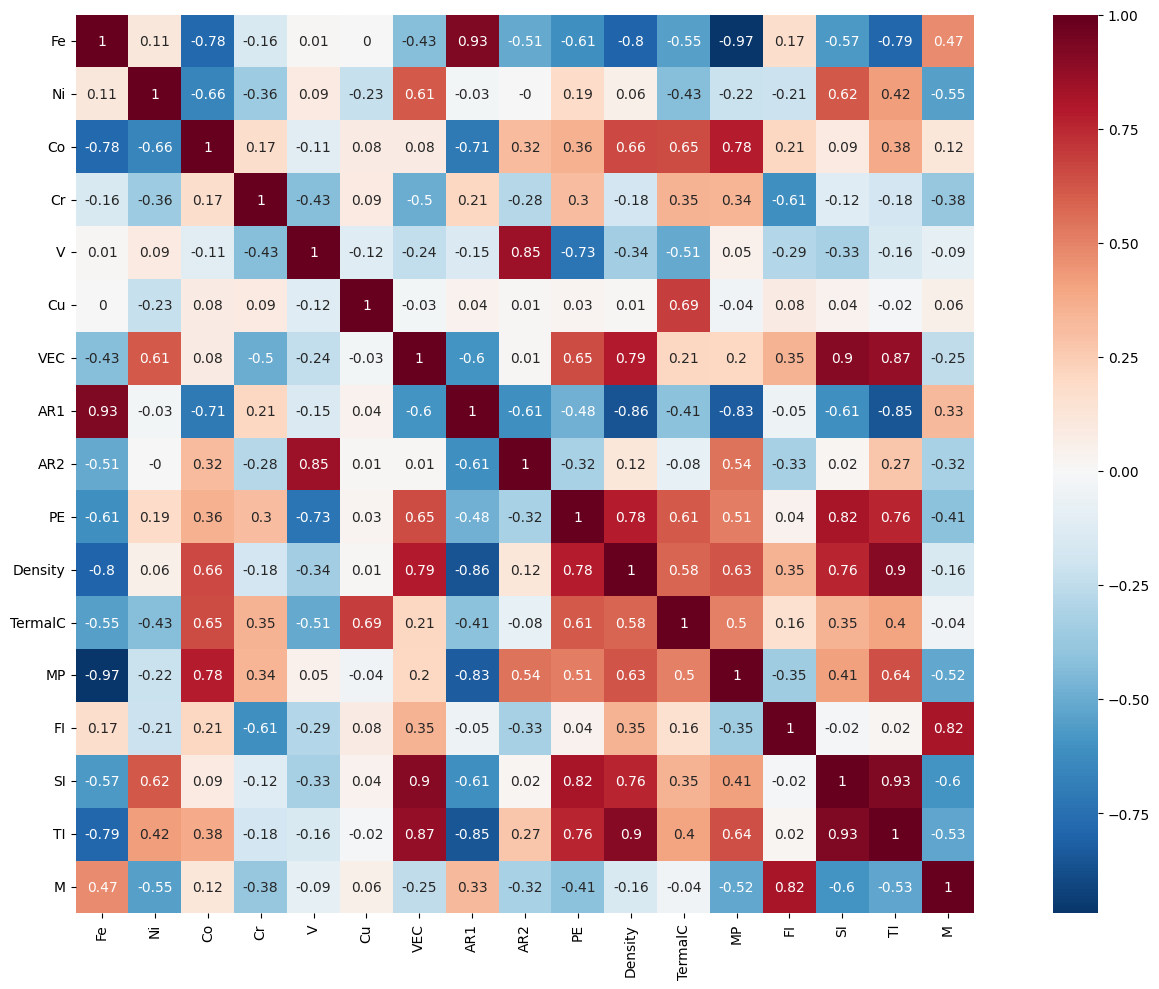

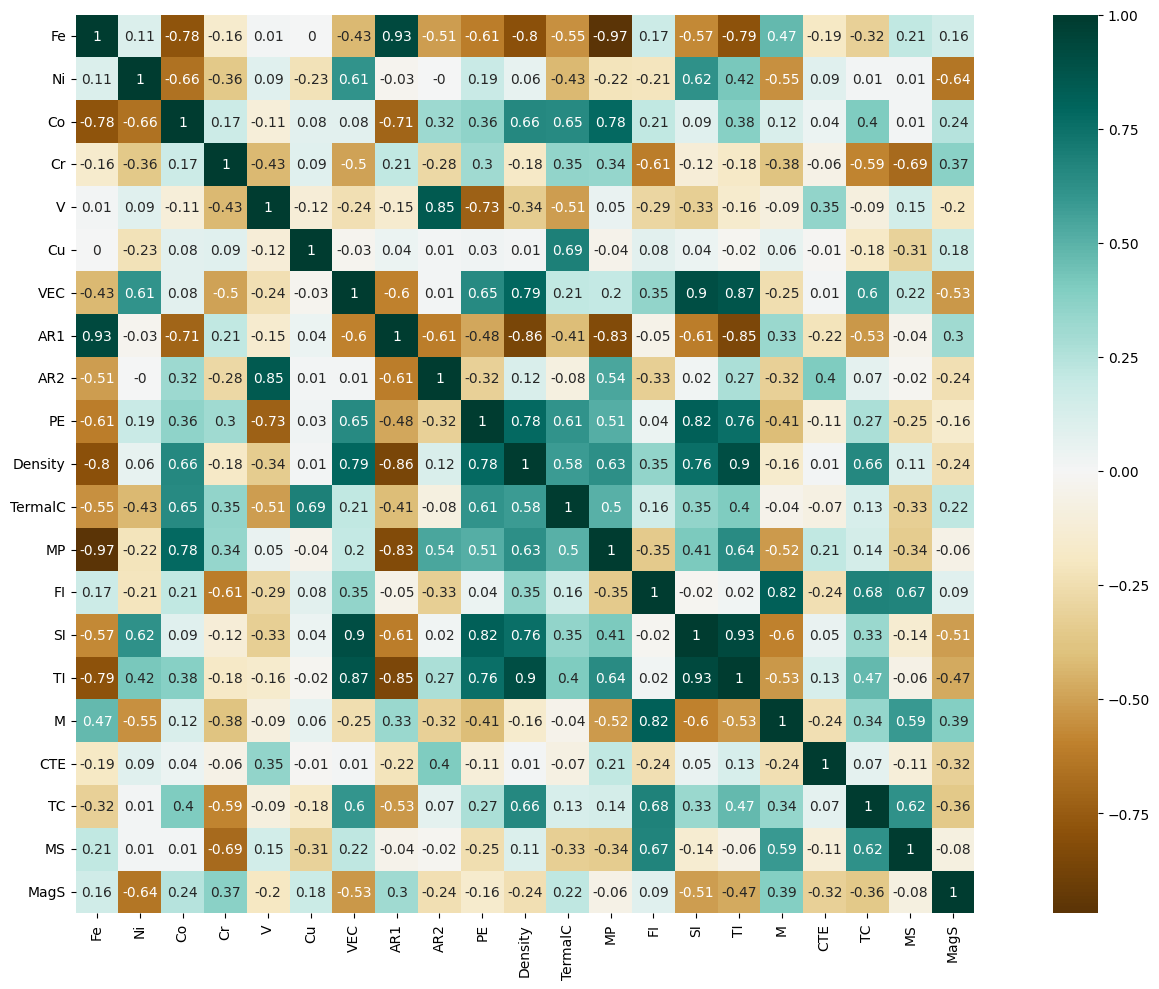

In [3]:

#X.isnull().any()
#y.isnull().any()


print(f"Shape of input vector {np.shape(X)}")
print(f"Shape of output y {np.shape(y)}")
print(y.min(), y.max())
correlation_X = X.corr()
correlation = data.corr(method='pearson')
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_X.round(2), annot = True, cmap='RdBu_r', square=True, center=0) #RdBu_r, Blues, BrBG
plt.tight_layout()
plt.savefig("Pearson_correlation_coff_X.png", dpi = 400)
plt.figure(figsize=(16, 10))
sns.heatmap(correlation.round(2), annot = True, cmap='BrBG', square=True, center=0)
plt.tight_layout()
plt.savefig("Pearson_correlation_coff_Xny.png", dpi = 400)
plt.show()

In [5]:
for i, columns in  enumerate(np.transpose(X.values)):
    ksstat, p_value = lilliefors(columns)
    if p_value < 0.05:
        print(f'Column {X.columns[i]} does not come from a normal distribution and has a p-value {p_value}')

Column Fe does not come from a normal distribution and has a p-value 0.015602835965859142
Column Ni does not come from a normal distribution and has a p-value 0.0009999999999998899
Column Co does not come from a normal distribution and has a p-value 0.00892223768507791
Column Cr does not come from a normal distribution and has a p-value 0.0009999999999998899
Column V does not come from a normal distribution and has a p-value 0.0009999999999998899
Column Cu does not come from a normal distribution and has a p-value 0.0009999999999998899
Column VEC does not come from a normal distribution and has a p-value 0.0009999999999998899
Column AR1 does not come from a normal distribution and has a p-value 0.0009999999999998899
Column AR2 does not come from a normal distribution and has a p-value 0.0009999999999998899
Column PE does not come from a normal distribution and has a p-value 0.0009999999999998899
Column Density does not come from a normal distribution and has a p-value 0.000999999999999

Features eliminated: ['Density', 'AR1', 'VEC', 'M', 'Co', 'MP', 'PE', 'TermalC', 'V', 'Cr', 'Fe', 'SI']
Index(['Ni', 'Cu', 'AR2', 'FI', 'TI'], dtype='object')
  Feature       VIF
0      Ni  1.152004
1      Cu  1.094523
2     AR2  1.232274
3      FI  1.237605
4      TI  1.188916


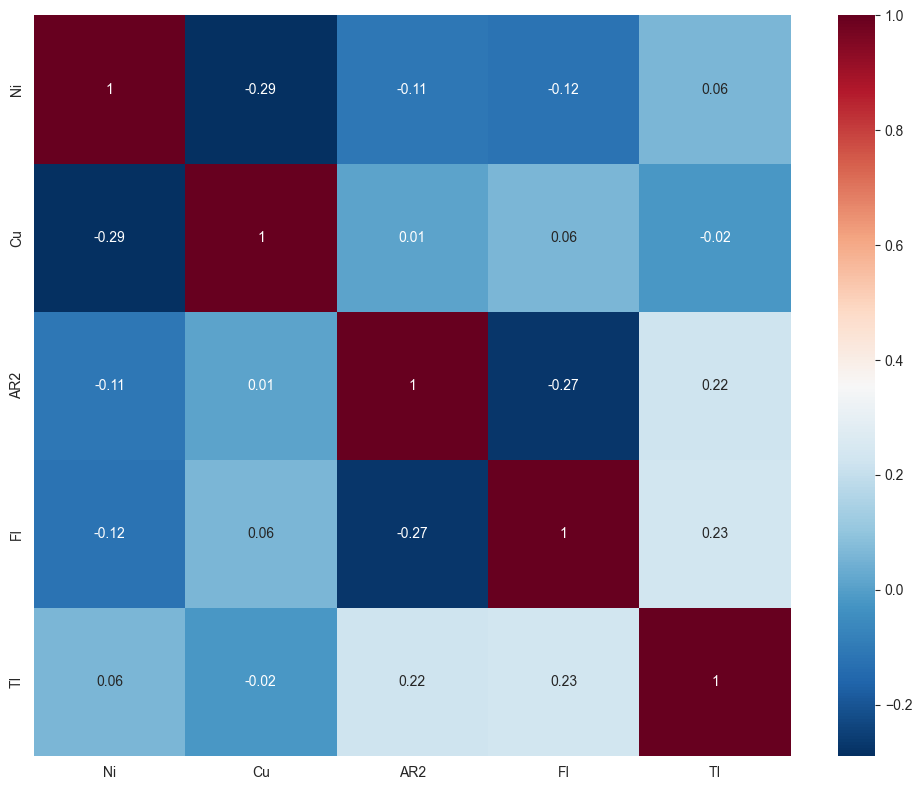

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(df, threshold):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    vif = pd.DataFrame()
    vif['Feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df_scaled, i) for i in range(df_scaled.shape[1])]
    return vif

eliminated_features = []
df = X.copy()
while True:
    
    threshold = 10.0
    vif = calculate_vif(df, threshold)
    max_vif = vif['VIF'].max()
    if max_vif < threshold:
        break
    eliminate_features = vif.loc[vif['VIF'].idxmax(), 'Feature']
    eliminated_features.append(eliminate_features)
    df = df.drop(columns=[eliminate_features])
    #print(f"Eliminated - {eliminate_features}")
    #print(vif)

print(f"Features eliminated: {eliminated_features}")
print(df.columns)
print(vif)
X_trimmed = X[df.columns.to_list()]
plt.figure(figsize=(10, 8))
sns.heatmap(X_trimmed.corr().round(2), annot=True, cmap='RdBu_r')
plt.tight_layout()
plt.savefig("VIF_trimmed_features.png", dpi=400)
plt.show()

In [7]:
import warnings
warnings.filterwarnings("ignore")
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
mae = mean_absolute_error(y_test, y_pred)
mae

0.2995581490176852


3.1292243775063353

In [ ]:
import warnings
warnings.filterwarnings("ignore")
sil_score = []
for i in range(2, 101):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    s_score = silhouette_score(X, labels)
    sil_score.append(s_score)
plt.figure(figsize=(10,6))
plt.plot(range(2, 101), sil_score, marker='o')
plt.show()

In [9]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X.values[:, 0], X.values[:, 1], X.values[:, 2], c=labels, cmap='viridis')
#centroids = kmeans.cluster_centers_
#ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c = 'red', marker = 'o', s=100)
#

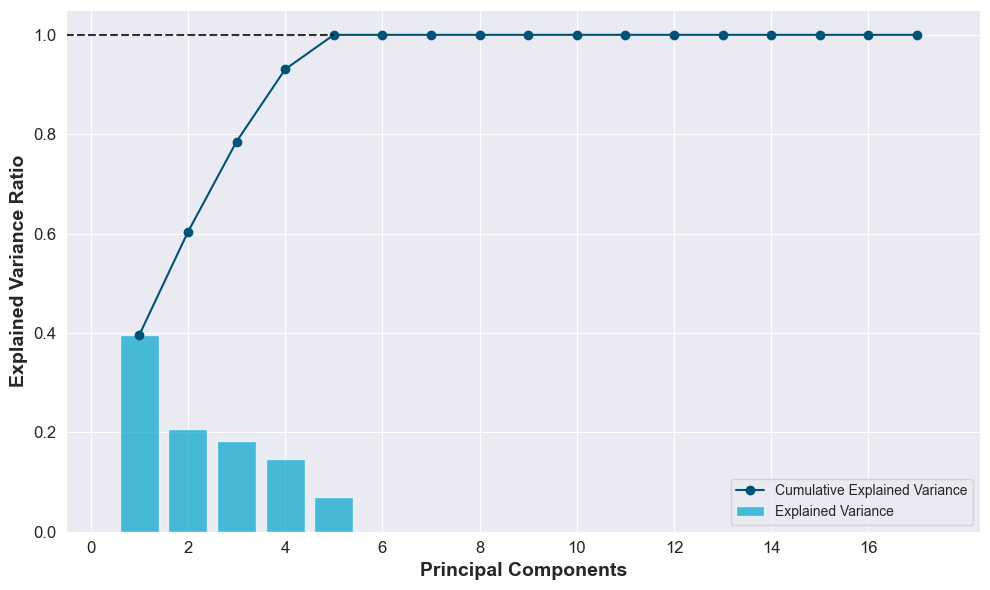

In [10]:
sns.set_style('darkgrid')
pca = PCA()
X_transformed = pca.fit_transform(X_scaled)
variance_ratio = pca.explained_variance_ratio_
#plt.figure(figsize=(10, 8))
#plt.plot(range(1, len(variance_ratio) + 1),variance_ratio)

cumulative_explained_variance = np.cumsum(variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1),cumulative_explained_variance, marker = 'o', color = '#005377', label = 'Cumulative Explained Variance')
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.7, color='#00A5CF', label = 'Explained Variance')
plt.hlines(y=1.0, xmin = -0.5, xmax = 5.0, linestyle = '--', alpha = 0.8, color = 'black')
plt.legend(loc='lower right')
xticks = np.arange(0, len(variance_ratio)+1, 2)
plt.xticks(xticks)
plt.xlim(left=-0.5)
plt.xlabel('Principal Components', fontsize=14,fontweight = 'bold')
plt.ylabel('Explained Variance Ratio', fontsize=14,fontweight = 'bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('PCA_variance_captured.png', dpi=400)
plt.show() 
pca_model = PCA(n_components=5)
X_model = pca_model.fit_transform(X_scaled)

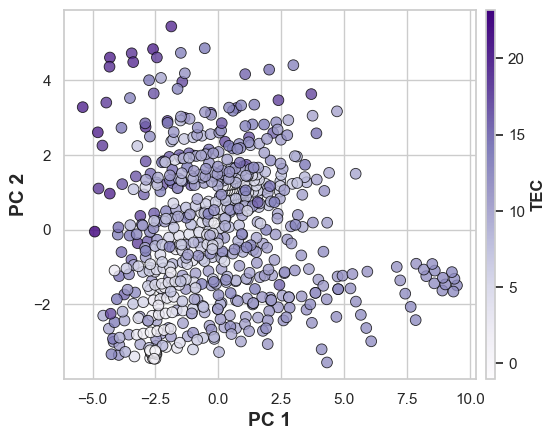

In [11]:
pca_two = PCA(n_components=2)
X_transformed = pca_two.fit_transform(X_scaled)
eigenvectors = pca_two.components_.T

sns.set(style="whitegrid")
plt.figure()
scatter = sns.scatterplot(x=X_transformed[:, 0].ravel(),
    y=X_transformed[:, 1].ravel(),
    hue=y.values.ravel(),                    
    palette="Purples",        
    edgecolor="black",
    alpha=0.8,
    s=60,  
    legend=False                   
)
norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
sm.set_array([])
#scale = 3
#for i in range(eigenvectors.shape[1]):
#    plt.arrow(0,0,eigenvectors[i, 0]*scale, eigenvectors[i, 1]*scale, color ='darkred', alpha=0.8, head_width = 0.25)
#    plt.text(eigenvectors[i, 0] * scale * 1.2, 
#             eigenvectors[i, 1] * scale * 1.2, 
#             X.columns[i], color='black', fontsize=14, ha='center', va='center')


cbar = plt.colorbar(sm, aspect=40, pad=0.02)
cbar.set_label('TEC', fontsize=12, fontweight='bold')

plt.xlabel('PC 1', fontsize=14, fontweight='bold')
plt.ylabel('PC 2', fontsize=14, fontweight='bold')
plt.savefig("PCA_plot.png", dpi=400)
plt.show()

In [ ]:
sns.set(style="whitegrid")

tsne = TSNE(random_state=42)
x_tsne = tsne.fit_transform(X_scaled)
cluster_range = range(2,11)
silhoutte_scores = []
n_clusters = 5
kmeans  = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(x_tsne)

plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=x_tsne[:, 0].ravel(),
    y=x_tsne[:, 1].ravel(),
    hue=y.values.ravel(),                    
    palette="Blues_r",        
    edgecolor="black",
    alpha=0.8,
    s=60,  
    legend=False                   
)
for i in range(n_clusters):
    cluster_points = x_tsne[clusters == i]
    center = kmeans.cluster_centers_[i]
    radius = np.max(np.linalg.norm(cluster_points - center, axis=1)) 
    circle = plt.Circle(center, radius, color="black", fill=False, linestyle="--", linewidth=1.2, alpha = 0.8)
    plt.gca().add_patch(circle)
norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=40, pad=0.08)
cbar.set_label('TEC', fontsize=12, fontweight='bold')
#plt.xlim(right=44)
plt.ylim(bottom=-35)
plt.xlabel("t-SNE 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE 2", fontsize=14, fontweight='bold')
plt.savefig('tsne_plot.png', dpi=400)
plt.show()

Selected Features are Index(['VEC', 'AR2', 'Density', 'TI', 'M'], dtype='object')
Feature ranking is [11 10  6  5 12 13  1  4  1  3  1  8  9  2  7  1  1]


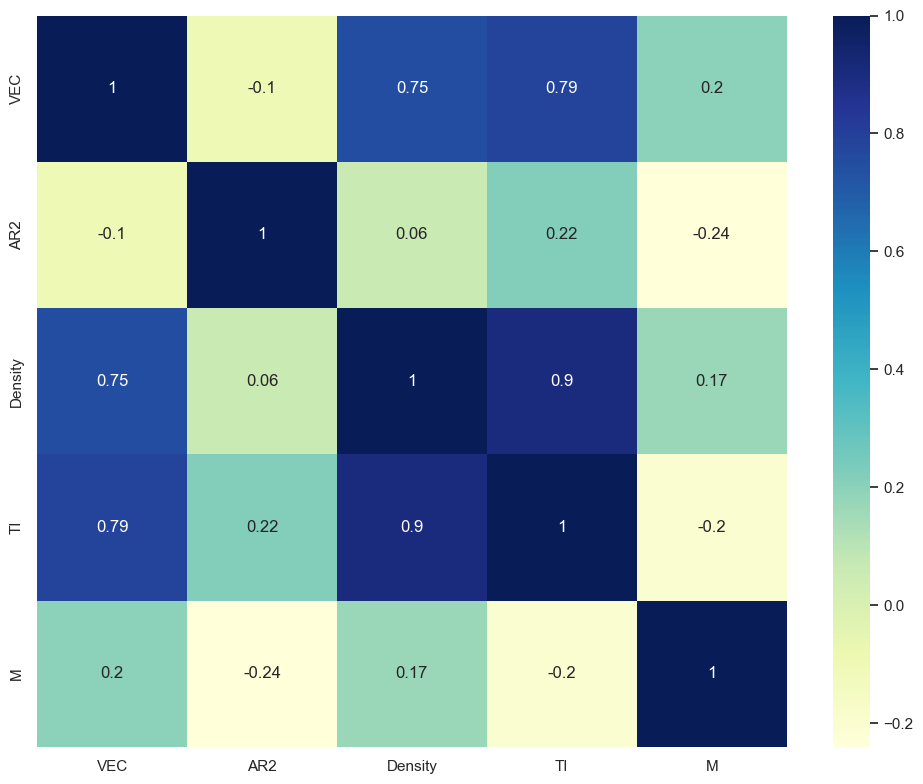

In [13]:


random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(random_forest_regressor, n_features_to_select=5)
rfe.fit(X_scaled, y.values.ravel())
print(f"Selected Features are {X.columns[rfe.support_]}")
print(f"Feature ranking is {rfe.ranking_}")
X_rfe = X[X.columns[rfe.support_]]
plt.figure(figsize=(10, 8))
sns.heatmap(X_rfe.corr().round(2), annot=True, cmap='YlGnBu')
plt.tight_layout()
#plt.savefig("RFE_trimmed_features.png", dpi=400)
plt.show()
#X_rfe_train, X_rfe_test,y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)


In [14]:
random_forest = RandomForestRegressor(random_state=1)
random_forest.fit(X_rfe_train, y_train)
y_pred = random_forest.predict(X_rfe_test)
r2_random_forest = r2_score(y_pred, y_test)
r2_random_forest

NameError: name 'X_rfe_train' is not defined

In [ ]:
np.shape(y)



(681, 1)

In [ ]:
seed = 42
test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
r2_scores_train = []
mae_values_train = []
rmse_values_train = []
r2_scores_test = []
mae_values_test = []
rmse_values_test = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfe)
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_model, y.values.ravel(), test_size=test_size, random_state=seed)
    model = RandomForestRegressor(random_state=seed)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    r2_scores_train.append(r2_train)
    mae_values_train.append(mae_train)
    rmse_values_train.append(rmse_train)
    
    r2_scores_test.append(r2_test)
    mae_values_test.append(mae_test)
    rmse_values_test.append(rmse_test)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(test_sizes, r2_scores_train, marker='o', color='b', linestyle='-', label='Train R² Score')
plt.plot(test_sizes, r2_scores_test, marker='o', color='c', linestyle='--', label='Test R² Score')
plt.xlabel('Test Size')
plt.ylabel('R² Score')
plt.title('R² Score vs Test Size')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(test_sizes, mae_values_train, marker='o', color='r', linestyle='-', label='Train MAE')
plt.plot(test_sizes, mae_values_test, marker='o', color='m', linestyle='--', label='Test MAE')
plt.xlabel('Test Size')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Test Size')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(test_sizes, rmse_values_train, marker='o', color='g', linestyle='-', label='Train RMSE')
plt.plot(test_sizes, rmse_values_test, marker='o', color='y', linestyle='--', label='Test RMSE')
plt.xlabel('Test Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs Test Size')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("PCA_vs_test_size.png", dpi = 400)
plt.show()

In [ ]:
sns.set_style('whitegrid') 

np.int = int
data = pd.read_csv("Data_base.csv") #dataset Rao et al
#data.describe()
data = data.iloc[:, 1:]

X = data[['Fe','Ni','Co','Cr','V','Cu','VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M']]
y = data[['TEC']]
var = X.var()
zero_var_columns = var[var == 0].index.to_list()

zero_var_columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#for column in X.columns:
#    sns.boxplot(x=X[column])
#    plt.title(f'Boxplot of {column}')
#    plt.savefig(f"boxplot_{column}.png")
#    plt.show()

contamination = 0.05 #contamination
iso_forest = IsolationForest(contamination=contamination, random_state=42) #IF
outliers_iso = iso_forest.fit_predict(X_scaled)
outliers_data_iso = data[outliers_iso == -1]
print(f"Isolation Forest - {len(outliers_data_iso)}")

lof = LocalOutlierFactor(n_neighbors=15, contamination=contamination) #LOF
outliers_lof = lof.fit_predict(X_scaled)
outliers_data_lof = data[outliers_lof == -1]
print(f"LOF - {len(outliers_data_lof)}")

svm = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination) #One class SVM
outliers_svm = svm.fit_predict(X_scaled)
outliers_data_svm = data[outliers_svm == -1]
print(f"One-Class SVM - {len(outliers_data_svm)}")


iso_outliers_set = set(outliers_data_iso.index)
lof_outliers_set = set(outliers_data_lof.index)
svm_outliers_set = set(outliers_data_svm.index)

common_outliers = iso_outliers_set.intersection(lof_outliers_set, svm_outliers_set)
print(f"Outlier detected by all three - {len(common_outliers)} they are{common_outliers}")

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(X_scaled)
#
#plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color='#ADB5BD', edgecolors='black',linewidths= 0.6, alpha=0.6, label='Inliers')
#
#plt.scatter(X_tsne[list(iso_outliers_set), 0], X_tsne[list(iso_outliers_set), 1],linewidths= 0.6, color='#6A0DAD',edgecolors='black', label='Isolation Forest Outliers')
#plt.scatter(X_tsne[list(lof_outliers_set), 0], X_tsne[list(lof_outliers_set), 1],linewidths= 0.6, color='#008080',edgecolors='black', label='LOF Outliers')
#plt.scatter(X_tsne[list(svm_outliers_set), 0], X_tsne[list(svm_outliers_set), 1],linewidths= 0.6, color='#40E0D0', edgecolors='black', label='One-Class SVM Outliers')
#
#plt.scatter(X_tsne[list(common_outliers), 0], X_tsne[list(common_outliers), 1], color='black', label='Common Outliers', marker='x')
#
#plt.legend()
#plt.savefig('tsne_plot_with_outliers.png', dpi = 400)
all_outliers = set.union(iso_outliers_set, lof_outliers_set, svm_outliers_set)

data_cleaned = data.drop(index=list(iso_outliers_set)) #IF outliers removed

X = data_cleaned[['Fe','Ni','Co','Cr','V','Cu','VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M']]
y = data_cleaned[['TEC']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled) #PCA transformation

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values.ravel(), test_size=0.2, random_state=42)

X_concat = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_train)], axis=0)
tsne = TSNE(n_components=2, random_state=1)
original_tsne = tsne.fit_transform(X_concat)

n_test = len(X_test)
test_tsne = original_tsne[:n_test]
train_tsne = original_tsne[n_test:]

plt.figure()
plt.scatter(original_tsne[:, 0], original_tsne[:, 1], color='grey', label='Original Data')
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], color='#953553', edgecolor='black', linewidth=0.5, alpha=0.75, label='Train Data')

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
#plt.title('t-SNE Visualization of Train and Test Data')
plt.legend()
plt.tight_layout()

plt.savefig('tsne_train_plot.png', dpi=400)
plt.show()